# ML ASSIGNMENT 3



In [ ]:
!pip install tensorflow-gpu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
# Folders for Model and Training History
os.makedirs("drive/My Drive/Models",exist_ok=True)
os.makedirs("drive/My Drive/Logs",exist_ok=True)

path_to_model="drive/My Drive/Models"
path_to_logs = "drive/My Drive/Logs"

# Task List
* CNN for Cats vs Dogs
* Compare results by using and not using regularization
* Build a gui for same

 # Load the dataset into colab

In [ ]:
!cp '/content/drive/My Drive/Copy of CatvsDogs.rar' '/content'

In [ ]:
#https://stackoverflow.com/questions/50315989/how-to-extract-rar-files-inside-google-colab
!pip install pyunpack
!pip install patool
from pyunpack import Archive
Archive('/content/Copy of CatvsDogs.rar').extractall('/content')

# Libraries

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D ,Flatten , BatchNormalization, Dropout

# Distribution of dataset

In [ ]:
print("No of Images in Train folder "+str(len(glob.glob('/content/train/*.jpg'))))
print("No of Images in Test folder "+str(len(glob.glob('/content/test1/*.jpg'))))

No of Images in Train folder 25000
No of Images in Test folder 12500


In [ ]:
print("No of DOGS Images in Train folder "+str(len([x for x in glob.glob('/content/train/*.jpg') if 'dog' in x.split("/")[-1] ])))
print("No of CATS Images in Train folder "+str(len([x for x in glob.glob('/content/train/*.jpg') if 'cat' in x.split("/")[-1] ])))

No of DOGS Images in Train folder 12500
No of CATS Images in Train folder 12500


# View the data

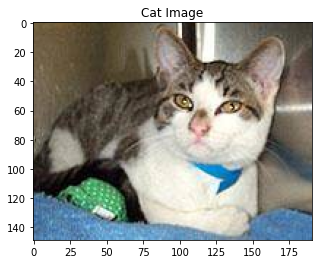

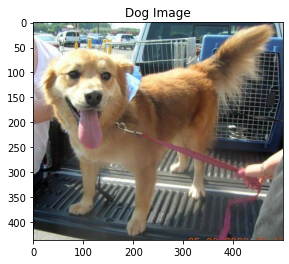

In [ ]:
img_path_cat  = glob.glob('/content/train/*.jpg')[-2]
img_path_dog  = glob.glob('/content/train/*.jpg')[2]
cat_img = cv2.cvtColor(cv2.imread(img_path_cat),cv2.COLOR_BGR2RGB) 
dog_img  =cv2.cvtColor(cv2.imread(img_path_dog),cv2.COLOR_BGR2RGB)
plt.imshow(cat_img)
plt.title("Cat Image")
plt.show()
plt.imshow(dog_img)
plt.title("Dog Image")
plt.show()

# Image AUgmentation and loading

## Load names n categories

In [ ]:
dataset = pd.DataFrame()

filename,category = [] , []

for path in glob.glob("/content/train/*.jpg"):
  name = path.split("/")[-1]
  if 'dog' in name:
    c = "1"
  elif 'cat' in name:
    c = "0"
  else:
    print("somehing wrong")
    continue
  filename.append(name)
  category.append(c)
dataset.insert(0,"filename",filename,)
dataset.insert(1,"class",category)

In [ ]:
dataset.head()

,filename,class
0,dog.3566.jpg,1
1,cat.8447.jpg,0
2,dog.11854.jpg,1
3,dog.6841.jpg,1
4,dog.11179.jpg,1


## Split Dataset in train and test

In [ ]:
sr = 0.3
train_df  =  dataset.sample(frac=1-sr)
test_df  = dataset.drop(train_df.index, axis=0)
print(f"No of samples in train and test are {train_df.size} and {test_df.size} respectively")

No of samples in train and test are 35000 and 15000 respectively


## Image augmentation

In [ ]:
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
train_gen = train_data_gen.flow_from_dataframe(dataframe=train_df,directory='/content/train',xcol='filename',ycol='class',target_size=(64,64),batch_size=32,class_mode='categorical')

valid_data_gen =  tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_gen = valid_data_gen.flow_from_dataframe(dataframe=test_df,directory='/content/train',xcol='filename',ycol='class',target_size=(64,64),batch_size=32,class_mode='categorical',random=False)


Found 17500 validated image filenames belonging to 2 classes.
Found 7500 validated image filenames belonging to 2 classes.


# CNN with regularization

# Set Constants


In [ ]:
model_name = 'c&d_cnn_r'
input_shape = (64,64,3)
activation_h = tf.keras.activations.relu
activation_o = tf.keras.activations.softmax
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
epochs =15

## Model build

In [ ]:
model_r = Sequential()
model_r.add(Conv2D(input_shape=input_shape,filters=32,kernel_size=(3,3),activation=activation_h))
model_r.add(BatchNormalization())
model_r.add(MaxPooling2D(2,2))
model_r.add(Dropout(0.25))


model_r.add(Conv2D(filters=64,kernel_size=(3,3),activation=activation_h))
model_r.add(BatchNormalization())
model_r.add(MaxPooling2D(2,2))
model_r.add(Dropout(0.25))

model_r.add(Conv2D(filters=128,kernel_size=(3,3),activation=activation_h))
model_r.add(BatchNormalization())
model_r.add(MaxPooling2D(2,2))
model_r.add(Dropout(0.25))

model_r.add(Flatten())
model_r.add(Dense(512,activation=activation_h))
model_r.add(BatchNormalization())
model_r.add(Dropout(0.5))
model_r.add(Dense(2,activation=activation_o))


model_r.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
model_r.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 14, 14, 64)       

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=f'{path_to_model}/{model_name}.h5',monitor='val_accuracy',save_best_only=True)
csv= tf.keras.callbacks.CSVLogger(f'{path_to_logs}/{model_name}.csv')

history = model_r.fit_generator(train_gen,epochs=epochs,validation_data=valid_gen,callbacks=[early_stopping,checkpointer,csv])


Epoch 1/15
547/547 [==============================] - 81s 149ms/step - loss: 0.7662 - accuracy: 0.6247 - val_loss: 0.6309 - val_accuracy: 0.6425
Epoch 2/15
547/547 [==============================] - 80s 147ms/step - loss: 0.5985 - accuracy: 0.6845 - val_loss: 0.5403 - val_accuracy: 0.7271
Epoch 3/15
547/547 [==============================] - 78s 143ms/step - loss: 0.5616 - accuracy: 0.7101 - val_loss: 0.5783 - val_accuracy: 0.7152
Epoch 4/15
547/547 [==============================] - 80s 147ms/step - loss: 0.5326 - accuracy: 0.7307 - val_loss: 0.5291 - val_accuracy: 0.7627
Epoch 5/15
547/547 [==============================] - 79s 145ms/step - loss: 0.5092 - accuracy: 0.7523 - val_loss: 0.7028 - val_accuracy: 0.6760
Epoch 6/15
547/547 [==============================] - 79s 144ms/step - loss: 0.4930 - accuracy: 0.7591 - val_loss: 0.9357 - val_accuracy: 0.6183
Epoch 7/15
547/547 [==============================] - 81s 148ms/step - loss: 0.4680 - accuracy: 0.7773 - val_loss: 0.4020 - val_ac

# CNN without regularization

# Set Constants


In [ ]:
model_name = 'c&d_cnn_wr'
input_shape = (64,64,3)
activation_h = tf.keras.activations.relu
activation_o = tf.keras.activations.softmax
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
epochs =15

## Model build

In [ ]:
model_wr = Sequential()
model_wr.add(Conv2D(input_shape=input_shape,filters=32,kernel_size=(3,3),activation=activation_h))
#model_r.add(BatchNormalization())
model_wr.add(MaxPooling2D(2,2))
#model_r.add(Dropout(0.25))


model_wr.add(Conv2D(filters=64,kernel_size=(3,3),activation=activation_h))
#model_r.add(BatchNormalization())
model_wr.add(MaxPooling2D(2,2))
#model_r.add(Dropout(0.25))

model_wr.add(Conv2D(filters=128,kernel_size=(3,3),activation=activation_h))
#model_r.add(BatchNormalization())
model_wr.add(MaxPooling2D(2,2))
#model_r.add(Dropout(0.25))

model_wr.add(Flatten())
model_wr.add(Dense(512,activation=activation_h))
#model_r.add(BatchNormalization())
#model_r.add(Dropout(0.5))
model_wr.add(Dense(2,activation=activation_o))


model_wr.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
model_wr.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 4608)            

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=f'{path_to_model}/{model_name}.h5',monitor='val_accuracy',save_best_only=True)
csv= tf.keras.callbacks.CSVLogger(f'{path_to_logs}/{model_name}.csv')

history = model_wr.fit_generator(train_gen,epochs=epochs,validation_data=valid_gen,callbacks=[early_stopping,checkpointer,csv])


Epoch 1/15
547/547 [==============================] - 76s 139ms/step - loss: 0.4406 - accuracy: 0.7934 - val_loss: 0.3631 - val_accuracy: 0.8419
Epoch 2/15
547/547 [==============================] - 79s 144ms/step - loss: 0.4183 - accuracy: 0.8079 - val_loss: 0.3509 - val_accuracy: 0.8449
Epoch 3/15
547/547 [==============================] - 77s 140ms/step - loss: 0.4018 - accuracy: 0.8137 - val_loss: 0.4166 - val_accuracy: 0.8148
Epoch 4/15
547/547 [==============================] - 77s 140ms/step - loss: 0.3838 - accuracy: 0.8271 - val_loss: 0.3494 - val_accuracy: 0.8428
Epoch 5/15
547/547 [==============================] - 79s 145ms/step - loss: 0.3716 - accuracy: 0.8307 - val_loss: 0.3231 - val_accuracy: 0.8588
Epoch 6/15
547/547 [==============================] - 76s 140ms/step - loss: 0.3618 - accuracy: 0.8370 - val_loss: 0.3417 - val_accuracy: 0.8519
Epoch 7/15
547/547 [==============================] - 77s 140ms/step - loss: 0.3497 - accuracy: 0.8463 - val_loss: 0.3075 - val_ac

# Compare CNN with regurlarization vs CNN Without Regularization

In [ ]:
model_r = tf.keras.models.load_model('/content/drive/My Drive/Models/c&d_cnn_r.h5')
model_wr = tf.keras.models.load_model('/content/drive/My Drive/Models/c&d_cnn_wr.h5')

In [ ]:
logs_r = pd.read_csv('/content/drive/My Drive/Logs/c&d_cnn_r.csv')
logs_wr = pd.read_csv('/content/drive/My Drive/Logs/c&d_cnn_wr.csv')


## Compare Training

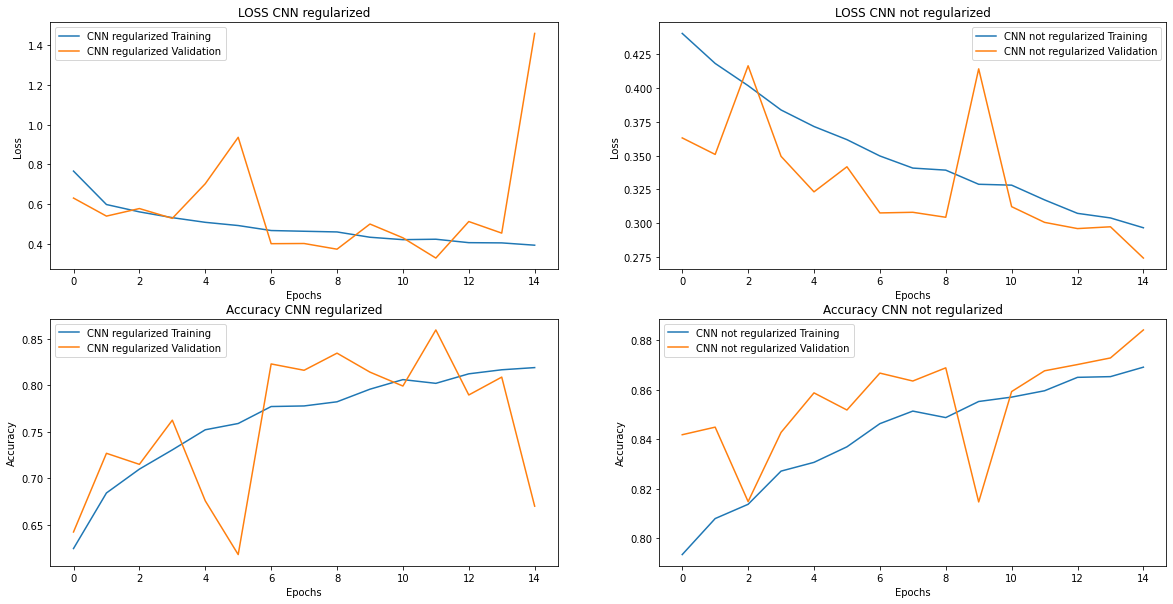

In [32]:

fig, axs = plt.subplots(2, 2,figsize=(20,10))

axs[0,0].plot(logs_r['loss'],label='CNN regularized Training')
axs[0,0].plot(logs_r['val_loss'],label='CNN regularized Validation')
axs[0,0].set_title('LOSS CNN regularized')
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss")
axs[0,0].legend(loc="best")

axs[0,1].plot(logs_wr['loss'],label='CNN not regularized Training')
axs[0,1].plot(logs_wr['val_loss'],label='CNN not regularized Validation')
axs[0,1].set_title('LOSS CNN not regularized')
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Loss")
axs[0,1].legend(loc="best")

axs[1,0].plot(logs_r['accuracy'],label='CNN regularized Training')
axs[1,0].plot(logs_r['val_accuracy'],label='CNN regularized Validation')
axs[1,0].set_title('Accuracy CNN regularized')
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Accuracy")
axs[1,0].legend(loc="best")


axs[1,1].plot(logs_wr['accuracy'],label='CNN not regularized Training')
axs[1,1].plot(logs_wr['val_accuracy'],label='CNN not regularized Validation')
axs[1,1].set_title('Accuracy CNN not regularized')
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Accuracy")
axs[1,1].legend(loc="best")








## Compare Evaluaion


### Accuracy & Loss

In [ ]:
loss_r, accuracy_r  = model_r.evaluate_generator(train_gen,verbose=0)
loss_wr, accuracy_wr  = model_wr.evaluate_generator(train_gen,verbose=0)
print(f"Training accuracy CNN regularized :{round(accuracy_r*100,4)} %")
print(f"Training accuracy CNN not regularized :{round(accuracy_wr*100,4)} %")
print(f"Training Loss CNN regularized:{loss_r}")
print(f"Training Loss CNN not regularized :{loss_wr}")

Training accuracy CNN regularized :78.2971 %
Training accuracy CNN not regularized :86.3086 %
Training Loss CNN regularized:0.470324844121933
Training Loss CNN not regularized :0.30643707513809204


In [ ]:
loss_r, accuracy_r  = model_r.evaluate_generator(valid_gen,verbose=0)
loss_wr, accuracy_wr  = model_wr.evaluate_generator(valid_gen,verbose=0)
print(f"Validation accuracy CNN regularized :{round(accuracy_r*100,4)} %")
print(f"Validation accuracy CNN not regularized :{round(accuracy_wr*100,4)} %")
print(f"Validation Loss CNN regularized:{loss_r}")
print(f"Validation Loss CNN not regularized :{loss_wr}")

Validation accuracy CNN regularized :85.96 %
Validation accuracy CNN not regularized :88.4267 %
Validation Loss CNN regularized:0.32984429597854614
Validation Loss CNN not regularized :0.27402567863464355


## Compare Classification Report

In [ ]:
import numpy as np
p_r=model_r.predict_generator(valid_gen)
p_wr=model_wr.predict_generator(valid_gen)
p_r= [np.argmax(x) for x in p_r]
p_wr = [np.argmax(x) for x in p_wr]

Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print("Cnn reguralized Classification report")
print(classification_report(valid_gen.classes,p_r))
print("Cnn not reguralized Classification report")
print(classification_report(valid_gen.classes,p_wr))

Cnn reguralized Classification report
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      3730
           1       0.50      0.49      0.49      3770

    accuracy                           0.50      7500
   macro avg       0.50      0.50      0.50      7500
weighted avg       0.50      0.50      0.50      7500

Cnn not reguralized Classification report
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      3730
           1       0.50      0.49      0.50      3770

    accuracy                           0.50      7500
   macro avg       0.50      0.50      0.50      7500
weighted avg       0.50      0.50      0.50      7500



## Confusion Matrix

Text(0.5, 1.0, 'Not Regularized')

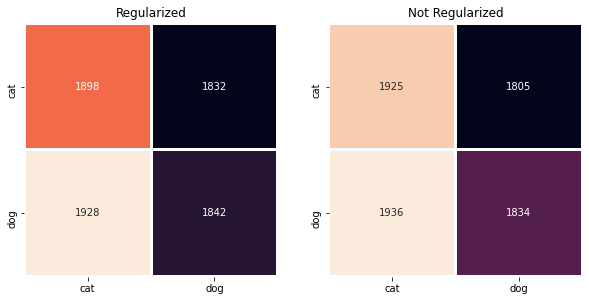

In [28]:
import seaborn as sns
labels =  ['cat','dog']
cm_r=confusion_matrix(valid_gen.classes,p_r)
cm_wr=confusion_matrix(valid_gen.classes,p_wr)
fig, axs = plt.subplots(1, 2,figsize=(10,5))

sns.heatmap(cm_r,square=True,cbar=False,xticklabels=labels,yticklabels=labels,annot=True,fmt="d",linewidths=2,ax=axs[0])
axs[0].set_title("Regularized")

sns.heatmap(cm_wr,square=True,cbar=False,xticklabels=labels,yticklabels=labels,annot=True,fmt="d",linewidths=2,ax=axs[1])
axs[1].set_title("Not Regularized")

# Stream lit Web App

## Install py depedencies

In [ ]:
!pip install pyngrok

In [ ]:
!pip install streamlit

## App.py

In [41]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
from PIL import Image , ImageOps
import cv2 
import numpy as np

labels =  ['cat', 'dog']
  
st.set_option('deprecation.showfileUploaderEncoding',False)
@st.cache(allow_output_mutation=True)
def lm():
  
  model = tf.keras.models.load_model('/content/drive/My Drive/Models/c&d_cnn_wr.h5')
  return model

model = lm()

st.write("""
  # Cat Dog  Clasifier
""")
file = st.file_uploader("Upload an Image",type=['jpeg','jpg','png'])

def import_and_predict(image_data,model):


  size=(64,64)
  img = ImageOps.fit(image_data,size,Image.ANTIALIAS)
  img = np.asarray(img)
  img = img[np.newaxis,...]
  l = np.argmax(model.predict(img))
  i  = labels[l]
  return i

if file is None:
  st.text("Pls upload image")
else:
  image = Image.open(file)
  st.image(image,use_column_width=True)
  p = import_and_predict(image , model)
  st.success(str(p))



Overwriting app.py


## Download Hosting Dependencies

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

In [43]:
!unzip /content/ngrok-stable-linux-amd64.zip

Archive:  /content/ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [44]:
!./ngrok authtoken 1gXagyREVZG8UEArEmla3g8urHp_7r2v3jmN7PjoHhvwmCT2P

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


## Run App.py

In [45]:
!nohup streamlit run app.py &

nohup: appending output to 'nohup.out'


In [46]:
from pyngrok import ngrok
url = ngrok.connect(port=8501)
url

'http://8297d43742be.ngrok.io'